In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
import math

In [2]:
def create_datapoints(N):
    x = np.random.rand(N)
    y = np.random.rand(N)
    colors = ['r' if x else 'b' for x in np.random.randint(2, size=N)]
    coords = [(a,b) for a,b in zip(x.tolist(), y.tolist())]
    data = [(coords[i][0], coords[i][1], colors[i]) for i in range(N)]
    return x, y, data, colors

In [3]:
def compute_entropy(p1, p2):
    if p1==p2==0:
        return 0 
    elif p1==0:
        return - p2 * math.log(p2)
    elif p2==0:
        return - p1 * math.log(p1)
    else:
        return - p1 * math.log(p1) - p2 * math.log(p2)

In [7]:
def find_weak_learner(points):
    """
    Args: 
    Takes the data and outputs a weak learner. This weak learner looks at all the horizontal and vertical lines and 
    picks a line that maximizes the information gain when splitting the decision tree. 
    
    Returns:
    A tuple containing the axis, dividing point and the color to the left or above. 
    """
    N = len(points)
    blue = Counter([x[2] for x in points])['b'] 
    red = N - blue  
    
    current_entropy = compute_entropy(blue/N, red/N) 
    
    data_x_sorted = deepcopy(points)
    data_x_sorted.sort(key= lambda x:x[0])

    data_y_sorted = deepcopy(points)
    data_y_sorted.sort(key= lambda x:x[1])
    
    xy_candidates = [] 
    for direction in [data_x_sorted, data_y_sorted]:
        l_blue, l_red, r_blue, r_red, l_count, r_count = 0, 0, blue, red, 0, N
        min_entropy = current_entropy 
        min_index = -1 
        right_or_above_color = 'b'
        for i in range(N-1):
            if direction[i][2]=='b':
                l_blue  += 1
                r_blue  -= 1 
            else:
                l_red += 1
                r_red -= 1 

            l_count += 1
            r_count -= 1

            left_entropy = compute_entropy(l_blue/l_count, l_red/l_count)
            right_entropy = compute_entropy(r_blue/r_count, r_red/r_count)
            split_entropy = (l_count * left_entropy + r_count * right_entropy)/N 
        
            if split_entropy < min_entropy:
                min_entropy = split_entropy
                min_index = i 
                if r_red > r_blue:
                    right_or_above_color = 'r'
                else:
                    right_or_above_color = 'b'
                
        xy_candidates.append((min_index, min_entropy, right_or_above_color))
        
    if xy_candidates[0][1] < xy_candidates[1][1]:
        return 'x', 0.5*(data_x_sorted[xy_candidates[0][0]][0] + data_x_sorted[xy_candidates[0][0] + 1][0]), xy_candidates[0][2]
    else:
        return 'y', 0.5*(data_y_sorted[xy_candidates[1][0]][1] + data_y_sorted[xy_candidates[1][0] + 1][1]), xy_candidates[1][2]

In [8]:
def find_adaboost_learner(points, T):
    """
    Finds the strong PAC learner through Ada-Boost learner. Takes the data points and use them to find weak 
    learners in each iteration of the boosting algorithm. T is the total number of boosting iterations. 
    
    Return the complex boosting learner. 
    """
    N = len(points)
    D_vec = [1/N for _ in range(N)]
    weak_learners = [] 
    
    for _ in range(T): 
        

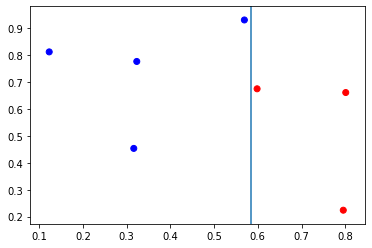

r


In [16]:
x, y, data1, colors = create_datapoints(7)
plt.scatter(x, y,  c=colors)
axis, num, color = find_weak_learner(data1)
if axis == 'x':
    plt.axvline(x=num)
elif axis == 'y':
    plt.axhline(y=num)
plt.show()
print(color)